In [4]:
# !pip install tensorflow

import csv
import random
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from scipy.stats import linregress
import pandas as pd
import re
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

pd.set_option('display.max_columns', 100)
style.use("fivethirtyeight")

print(tf.__version__)

NameError: name 'style' is not defined

# EMBEDDING

In [ ]:

def clean_text(text): 
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", \
                 "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", \
                 "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", \
                 "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", \
                 "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", \
                 "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", \
                 "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", \
                 "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", \
                 "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", \
                 "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", \
                 "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", \
                 "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", \
                 "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", \
                 "your", "yours", "yourself", "yourselves" ]
    text = text.lower()
    words = text.split()
    no_words = [w for w in words if w not in stopwords]
    text = " ".join(no_words)
    
    text = re.sub(r'\|','', text)
    text = re.sub(r'-.+','', text)
    text = re.sub('<[^>]*>', '', text)
    text = re.sub(r'[^\w\s]',' ', text)
    text = re.sub(r'(?<!\S)\d+(?!\S)',' ', text)
    text = re.sub(r'http.+','', text)
    text = re.sub(r'\s\s',' ', text)
#     text = ' '.join(list(filter(lambda t: len(t)>1, text.split()) ))
#     text = re.sub(r'\sлот\s|аналог|\sабо\s|\sдк\s|\sдля\s|\sта\s|\sпо\s|\sна\s|\sдо\s|\sза\s|\sкод|\sдсту|еквівалент|ін\s|набір|нк\s|cpv',' ', text).replace('  ',' ')
    return text



In [5]:
vocab_size = 10000
embedding_dim = 64
max_length = 15
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)


# Load model

In [6]:
with open("./embedded_220612/tokenizer_data.pkl", 'rb') as f:
    data = pickle.load(f)
    tokenizer = data['tokenizer']
    num_words = data['num_words']
    maxlen = data['maxlen']
    
new_model = tf.keras.models.load_model('./embedded_220612')
new_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 64)          640000    
                                                                 
 global_average_pooling1d_11  (None, 64)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_22 (Dense)            (None, 64)                4160      
                                                                 
 dense_23 (Dense)            (None, 1)                 65        
                                                                 
Total params: 644,225
Trainable params: 644,225
Non-trainable params: 0
_________________________________________________________________


In [7]:
def prepare(text):
# print(d['title'])
    text = text.apply(clean_text)
    text = tokenizer.texts_to_sequences(text)
    text = pad_sequences(text, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    pred = (new_model.predict(text).reshape(-1) >= 0.9).astype(int)
    prob = (new_model.predict(text).reshape(-1))
    # print(pred,d['title'])
    # df['pred'] = pred
    # print('-----------------')
    return pred,prob
   

In [8]:
import os

files = [] 
for dirname, _, filenames in os.walk('./archive/'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        files.append(os.path.join(dirname, filename))

In [9]:
print(len(files))
files[:10]

278


['./archive/0819_UkraineCombinedTweetsDeduped.csv.gzip',
 './archive/0820_UkraineCombinedTweetsDeduped.csv.gzip',
 './archive/0821_UkraineCombinedTweetsDeduped.csv.gzip',
 './archive/0822_UkraineCombinedTweetsDeduped.csv.gzip',
 './archive/0823_UkraineCombinedTweetsDeduped.csv.gzip',
 './archive/0824_UkraineCombinedTweetsDeduped.csv.gzip',
 './archive/0825_UkraineCombinedTweetsDeduped.csv.gzip',
 './archive/0826_UkraineCombinedTweetsDeduped.csv.gzip',
 './archive/0827_UkraineCombinedTweetsDeduped.csv.gzip',
 './archive/0828_UkraineCombinedTweetsDeduped.csv.gzip']

In [10]:
data = []
for f in files:
    df = pd.read_csv(f, compression='gzip', index_col=0,encoding='utf-8', quoting=csv.QUOTE_ALL)
    df = df[(df['language']=='en')&(~df['location'].isin(['Ukraine','Kyiv, Ukraine','Україна','Kyiv','Украина']))][['location','text','extractedts','hashtags']]
    df['extractedts'] = df['extractedts'].replace('\s.+','', regex=True)
    pred,prob = prepare(df['text'])
    df['pred'] = pred
    # df['prob'] = prob
    # print(pred)   
    data.append({"date":df.iloc[0]['extractedts'],'total':len(df),'bad':len(df[df['pred']==1])})
    # data.append(time)
    print(f)

./archive/0819_UkraineCombinedTweetsDeduped.csv.gzip
./archive/0820_UkraineCombinedTweetsDeduped.csv.gzip
./archive/0821_UkraineCombinedTweetsDeduped.csv.gzip
./archive/0822_UkraineCombinedTweetsDeduped.csv.gzip
./archive/0823_UkraineCombinedTweetsDeduped.csv.gzip
./archive/0824_UkraineCombinedTweetsDeduped.csv.gzip
./archive/0825_UkraineCombinedTweetsDeduped.csv.gzip
./archive/0826_UkraineCombinedTweetsDeduped.csv.gzip
./archive/0827_UkraineCombinedTweetsDeduped.csv.gzip
./archive/0828_UkraineCombinedTweetsDeduped.csv.gzip
./archive/0829_UkraineCombinedTweetsDeduped.csv.gzip
./archive/0830_UkraineCombinedTweetsDeduped.csv.gzip
./archive/0831_UkraineCombinedTweetsDeduped.csv.gzip
./archive/0901_UkraineCombinedTweetsDeduped.csv.gzip
./archive/0902_UkraineCombinedTweetsDeduped.csv.gzip
./archive/0903_UkraineCombinedTweetsDeduped.csv.gzip
./archive/0904_UkraineCombinedTweetsDeduped.csv.gzip
./archive/0905_UkraineCombinedTweetsDeduped.csv.gzip
./archive/0906_UkraineCombinedTweetsDeduped.cs

C:\Users\Admin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


./archive/1001_UkraineCombinedTweetsDeduped.csv.gzip
./archive/1002_UkraineCombinedTweetsDeduped.csv.gzip
./archive/1003_UkraineCombinedTweetsDeduped.csv.gzip
./archive/1004_UkraineCombinedTweetsDeduped.csv.gzip
./archive/1005_UkraineCombinedTweetsDeduped.csv.gzip
./archive/1006_UkraineCombinedTweetsDeduped.csv.gzip
./archive/1007_UkraineCombinedTweetsDeduped.csv.gzip
./archive/1008_UkraineCombinedTweetsDeduped.csv.gzip
./archive/1009_UkraineCombinedTweetsDeduped.csv.gzip
./archive/1010_UkraineCombinedTweetsDeduped.csv.gzip
./archive/1011_UkraineCombinedTweetsDeduped.csv.gzip
./archive/1012_UkraineCombinedTweetsDeduped.csv.gzip
./archive/1013_UkraineCombinedTweetsDeduped.csv.gzip
./archive/1014_UkraineCombinedTweetsDeduped.csv.gzip
./archive/1015_UkraineCombinedTweetsDeduped.csv.gzip
./archive/1016_UkraineCombinedTweetsDeduped.csv.gzip
./archive/1017_UkraineCombinedTweetsDeduped.csv.gzip
./archive/1018_UkraineCombinedTweetsDeduped.csv.gzip
./archive/1019_UkraineCombinedTweetsDeduped.cs

C:\Users\Admin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (18,21,24,25,28) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


./archive/UkraineWar\UkraineWar\0422_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0423_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0424_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0425_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0426_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0427_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0428_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0429_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0430_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0501_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0502_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0503_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0504_UkraineCombinedTweetsDeduped.csv.gzip


C:\Users\Admin\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


./archive/UkraineWar\UkraineWar\0505_to_0507_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0508_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0509_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0510_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0511_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0512_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0513_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0514_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0515_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0516_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0517_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0518_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0519_UkraineCombinedTweetsDeduped.csv.gzip
./archive/Ukraine

C:\Users\Admin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


./archive/UkraineWar\UkraineWar\0808_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0809_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0810_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0811_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0812_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0813_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0814_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0815_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0816_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0817_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0818_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\UkraineCombinedTweetsDeduped20220227-131611.csv.gzip
./archive/UkraineWar\UkraineWar\UkraineCombinedTweetsDeduped_FEB27.csv.gzip
./archive/Ukra

In [14]:
twitter = pd.DataFrame(data)
twitter

,date,total,bad
0,2022-08-19,21871,628
1,2022-08-20,18929,541
2,2022-08-21,19305,607
3,2022-08-22,21134,732
4,2022-08-23,22389,731
...,...,...,...
273,2022-03-26,286461,6109
274,2022-03-27,512675,12335
275,2022-03-29,247561,5417
276,2022-03-30,235008,4997


In [19]:
twitter.sum()

date     2022-08-192022-08-202022-08-212022-08-222022-0...
total                                             35674118
bad                                                1046604
dtype: object

In [ ]:
# df = pd.concat(data, axis=0) 
# print(df.shape)
# # df['pred'].value_counts()

In [ ]:
# df

In [15]:
# df = df.rename(columns={0:'ua',1:'ru'}).reset_index()
# df['total'] = df['ua']+df['ru']
# df['per'] = df['ua']/df['total']

# df

In [16]:
# df2 = df.groupby(['extractedts'])[['ua','ru','total']].agg(['sum']).reset_index()
# df2.columns = ["_".join(pair) for pair in df2.columns]
# df2['date'] = pd.to_datetime(df2['extractedts_'])
# df2['per'] = df2['ua_sum']/df2['total_sum']

# df2

In [17]:
twitter.to_csv('twitter.csv', index=False)

<AxesSubplot:xlabel='date', ylabel='per'>

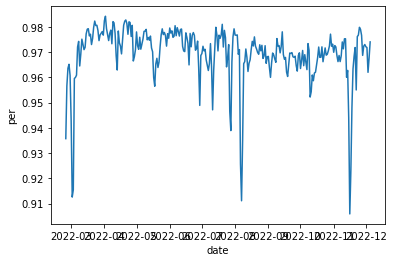

In [287]:
sns.lineplot(data=df2, x="date", y="per")

<AxesSubplot:xlabel='date', ylabel='bad'>

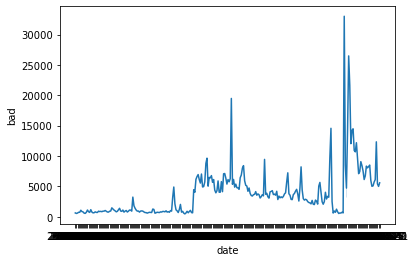

In [18]:
sns.lineplot(data=twitter, x="date", y="bad")

<AxesSubplot:xlabel='date', ylabel='ru_sum'>

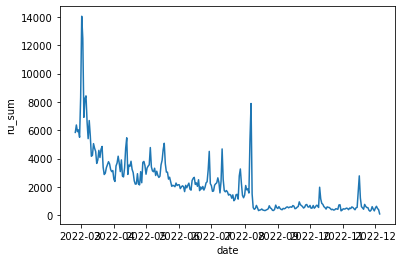

In [256]:
sns.lineplot(data=df2, x="date", y="ru_sum")

In [253]:
df2.dtypes

extractedts_            object
ua_sum                   int64
ru_sum                   int64
total_sum                int64
date            datetime64[ns]
dtype: object

In [292]:
df2[(df2['date']>'2022-11-01')]


,extractedts_,ua_sum,ru_sum,total_sum,date,per
251,2022-11-02,15619,441,16060,2022-11-02,0.972540
252,2022-11-03,15902,458,16360,2022-11-03,0.972005
253,2022-11-04,15727,510,16237,2022-11-04,0.968590
254,2022-11-05,13809,483,14292,2022-11-05,0.966205
255,2022-11-06,12325,399,12724,2022-11-06,0.968642
256,2022-11-07,14645,512,15157,2022-11-07,0.966220
257,2022-11-08,14664,477,15141,2022-11-08,0.968496
258,2022-11-09,22128,591,22719,2022-11-09,0.973987
259,2022-11-10,18860,558,19418,2022-11-10,0.971264
260,2022-11-11,18462,469,18931,2022-11-11,0.975226


In [293]:
df2[df2['date']=='2022-11-16']

,extractedts_,ua_sum,ru_sum,total_sum,date,per
265,2022-11-16,26800,2783,29583,2022-11-16,0.905926


In [61]:
au = pd.read_csv('./archive/1116_UkraineCombinedTweetsDeduped.csv.gzip', compression='gzip', index_col=0,encoding='utf-8', quoting=csv.QUOTE_ALL)
au = au[(au['language']=='en')&(~au['location'].isin(['Ukraine','Kyiv, Ukraine','Україна','Kyiv','Украина']))]
au.shape

(46160, 28)

In [62]:
au[:20]['hashtags'].to_list()

["[{'text': 'Kherson', 'indices': [35, 43]}]",
 "[{'text': 'Missile', 'indices': [11, 19]}, {'text': 'Poland', 'indices': [25, 32]}, {'text': 'G20', 'indices': [48, 52]}, {'text': 'G20BaliSummit', 'indices': [135, 149]}, {'text': 'Russia', 'indices': [210, 217]}]",
 "[{'text': 'Chemicalweapons', 'indices': [194, 210]}, {'text': 'OPCWinvestigate', 'indices': [213, 229]}, {'text': 'Turkey', 'indices': [232, 239]}]",
 "[{'text': 'ukraine', 'indices': [140, 148]}, {'text': 'mostshared', 'indices': [149, 160]}]",
 "[{'text': 'WWIII', 'indices': [161, 167]}, {'text': 'Ukraine', 'indices': [168, 176]}, {'text': 'Poland', 'indices': [177, 184]}, {'text': 'NATO', 'indices': [185, 190]}]",
 "[{'text': 'Putin', 'indices': [8, 14]}, {'text': 'Hitler', 'indices': [30, 37]}, {'text': 'PolandRussiaWar', 'indices': [64, 80]}, {'text': 'PutinWarCriminal', 'indices': [81, 98]}, {'text': 'UkraineRussianWar', 'indices': [99, 117]}, {'text': 'PutinHitler', 'indices': [118, 130]}]",
 "[{'text': 'Ukraine', '

In [64]:
pred,prob = prepare(au['text'])
au['pred'] = pred

In [65]:
au[au['pred']==1][:20]['hashtags'].to_list()

["[{'text': 'UkraineRussiaWar', 'indices': [152, 169]}]",
 "[{'text': 'NATO', 'indices': [101, 106]}, {'text': 'Poland', 'indices': [107, 114]}, {'text': 'UnitedStates', 'indices': [115, 128]}, {'text': 'WWIII', 'indices': [129, 135]}, {'text': 'Ukraine', 'indices': [136, 144]}]",
 "[{'text': 'WWIII', 'indices': [35, 41]}, {'text': 'NATO', 'indices': [42, 47]}, {'text': 'Russia', 'indices': [48, 55]}, {'text': 'Poland', 'indices': [56, 63]}]",
 "[{'text': 'Russia', 'indices': [83, 90]}]",
 "[{'text': 'WWIII', 'indices': [0, 6]}, {'text': 'Ukraine️', 'indices': [39, 48]}, {'text': 'Poland', 'indices': [61, 68]}, {'text': 'USA', 'indices': [105, 109]}, {'text': 'Russia', 'indices': [140, 147]}]",
 "[{'text': 'worldwar3', 'indices': [48, 58]}, {'text': 'Russia', 'indices': [128, 135]}, {'text': 'Ukraine', 'indices': [136, 144]}]",
 "[{'text': 'StopFundingRussia', 'indices': [210, 228]}, {'text': 'StandWithUkraine', 'indices': [230, 247]}, {'text': 'RussiansOffTheIce', 'indices': [256, 274

In [66]:
au[au['pred']==1][:20]['text'].to_list()

["I just think Ukraine is trying it's best to bring NATO to attack Russia. Even Poland isn't sure if Russia fired those 2 missiles that landed in Poland.\n#UkraineRussiaWar",
 'How the Armed Forces of Ukraine defeated the best Russian units. Frames that will go down in history\n#NATO #Poland #UnitedStates #WWIII #Ukraine #\nhttps://t.co/DeW3RwzviI',
 'Genz on there way to defend Poland #WWIII #NATO #Russia #Poland https://t.co/e0TgAiQmjj',
 "Why do Ashkenazi Zionist Jews show such hatred towards Europeans and in particular #Russia? They are not Hebrews, they are not Semites and their claim of 'antisemitism' is utter nonsense. Palestinians are Semites not Jews and the DNA evidence proves it.\n\nhttps://t.co/cz0WArCFdc",
 '#WWIII is not gonna start because some #Ukraine️ missile hit #Poland. It’s continuing to start since we (#USA) have caused a proxy war with #Russia thru Ukraine. 🙄',
 'As if we don’t have enough worries in life that #worldwar3 is trending. Like seriously wtf is happeni

# STATS

In [54]:
bad_tags = []
for f in files:
    df = pd.read_csv(f, compression='gzip', index_col=0,encoding='utf-8', quoting=csv.QUOTE_ALL)
    df['extractedts'] = df['extractedts'].replace('\s.+','', regex=True)
   
    en = df[(df['language']=='en')]
    
    withoutua = df[(df['language']=='en')&\
             (~df['location'].isin(['Ukraine','Kyiv, Ukraine','Україна','Kyiv','Украина']))]
    
    tags = df[
             (df['hashtags'].str.contains('IStandWithPutin|Istandwithrussia', regex=True))]
    
    
    tagsen = df[(df['language']=='en')&\
             (~df['location'].isin(['Ukraine','Kyiv, Ukraine','Україна','Kyiv','Украина']))&\
             (df['hashtags'].str.contains('IStandWithPutin|Istandwithrussia', regex=True))]
    
    bad_tags.append({'date':df.iloc[0]['extractedts'],\
                     'total':len(df),'en':len(en),'withoutua':len(withoutua)\
                     ,'tags':len(tags),'tagsen':len(tagsen)})
    print(f)

./archive/0819_UkraineCombinedTweetsDeduped.csv.gzip
./archive/0820_UkraineCombinedTweetsDeduped.csv.gzip
./archive/0821_UkraineCombinedTweetsDeduped.csv.gzip
./archive/0822_UkraineCombinedTweetsDeduped.csv.gzip
./archive/0823_UkraineCombinedTweetsDeduped.csv.gzip
./archive/0824_UkraineCombinedTweetsDeduped.csv.gzip
./archive/0825_UkraineCombinedTweetsDeduped.csv.gzip
./archive/0826_UkraineCombinedTweetsDeduped.csv.gzip
./archive/0827_UkraineCombinedTweetsDeduped.csv.gzip
./archive/0828_UkraineCombinedTweetsDeduped.csv.gzip
./archive/0829_UkraineCombinedTweetsDeduped.csv.gzip
./archive/0830_UkraineCombinedTweetsDeduped.csv.gzip
./archive/0831_UkraineCombinedTweetsDeduped.csv.gzip
./archive/0901_UkraineCombinedTweetsDeduped.csv.gzip
./archive/0902_UkraineCombinedTweetsDeduped.csv.gzip
./archive/0903_UkraineCombinedTweetsDeduped.csv.gzip
./archive/0904_UkraineCombinedTweetsDeduped.csv.gzip
./archive/0905_UkraineCombinedTweetsDeduped.csv.gzip
./archive/0906_UkraineCombinedTweetsDeduped.cs

C:\Users\Admin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


./archive/1001_UkraineCombinedTweetsDeduped.csv.gzip
./archive/1002_UkraineCombinedTweetsDeduped.csv.gzip
./archive/1003_UkraineCombinedTweetsDeduped.csv.gzip
./archive/1004_UkraineCombinedTweetsDeduped.csv.gzip
./archive/1005_UkraineCombinedTweetsDeduped.csv.gzip
./archive/1006_UkraineCombinedTweetsDeduped.csv.gzip
./archive/1007_UkraineCombinedTweetsDeduped.csv.gzip
./archive/1008_UkraineCombinedTweetsDeduped.csv.gzip
./archive/1009_UkraineCombinedTweetsDeduped.csv.gzip
./archive/1010_UkraineCombinedTweetsDeduped.csv.gzip
./archive/1011_UkraineCombinedTweetsDeduped.csv.gzip
./archive/1012_UkraineCombinedTweetsDeduped.csv.gzip
./archive/1013_UkraineCombinedTweetsDeduped.csv.gzip
./archive/1014_UkraineCombinedTweetsDeduped.csv.gzip
./archive/1015_UkraineCombinedTweetsDeduped.csv.gzip
./archive/1016_UkraineCombinedTweetsDeduped.csv.gzip
./archive/1017_UkraineCombinedTweetsDeduped.csv.gzip
./archive/1018_UkraineCombinedTweetsDeduped.csv.gzip
./archive/1019_UkraineCombinedTweetsDeduped.cs

C:\Users\Admin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (18,21,24,25,28) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


./archive/UkraineWar\UkraineWar\0422_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0423_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0424_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0425_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0426_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0427_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0428_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0429_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0430_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0501_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0502_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0503_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0504_UkraineCombinedTweetsDeduped.csv.gzip


C:\Users\Admin\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


./archive/UkraineWar\UkraineWar\0505_to_0507_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0508_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0509_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0510_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0511_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0512_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0513_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0514_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0515_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0516_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0517_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0518_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0519_UkraineCombinedTweetsDeduped.csv.gzip
./archive/Ukraine

C:\Users\Admin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


./archive/UkraineWar\UkraineWar\0808_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0809_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0810_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0811_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0812_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0813_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0814_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0815_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0816_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0817_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\0818_UkraineCombinedTweetsDeduped.csv.gzip
./archive/UkraineWar\UkraineWar\UkraineCombinedTweetsDeduped20220227-131611.csv.gzip
./archive/UkraineWar\UkraineWar\UkraineCombinedTweetsDeduped_FEB27.csv.gzip
./archive/Ukra

In [53]:
# df['location'].value_counts()[:50]

In [55]:
pd.DataFrame(bad_tags)

,date,total,en,withoutua,tags,tagsen
0,2022-08-19,47994,23179,21871,5,1
1,2022-08-20,44364,20103,18929,0,0
2,2022-08-21,47708,20242,19305,1,1
3,2022-08-22,46979,22168,21134,0,0
4,2022-08-23,50253,23760,22389,1,1
...,...,...,...,...,...,...
273,2022-03-26,411296,290989,286461,193,127
274,2022-03-27,768164,520599,512675,414,301
275,2022-03-29,364124,251751,247561,103,70
276,2022-03-30,348864,239541,235008,52,36


In [56]:
pd.DataFrame(bad_tags).to_csv('stats2.csv', index=False)

In [58]:
tags = pd.DataFrame(bad_tags)
tags['date'] = pd.to_datetime(tags['date'])
tags.dtypes

date         datetime64[ns]
total                 int64
en                    int64
withoutua             int64
tags                  int64
tagsen                int64
dtype: object

In [60]:
tags[tags['date']>'2022-11-01']

,date,total,en,withoutua,tags,tagsen
75,2022-11-02,46265,24762,23848,2,1
76,2022-11-03,45887,24627,23713,5,5
77,2022-11-04,48313,26561,25495,12,5
78,2022-11-05,45068,24170,23401,2,1
79,2022-11-06,41485,22094,21352,1,1
80,2022-11-07,61353,25016,24198,2,0
81,2022-11-08,43756,23287,22451,1,1
82,2022-11-09,63623,35542,34673,1,1
83,2022-11-10,50945,27900,26993,0,0
84,2022-11-11,60872,32315,30876,0,0


<AxesSubplot:xlabel='date', ylabel='tagsen'>

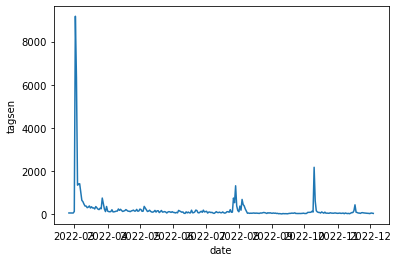

In [20]:
sns.lineplot(data=tags, x="date", y="tagsen")


In [41]:
tags[:3]

,date,total,en,withoutua,tags,tagsen
0,2022-08-19,47994,23179,21871,95,41
1,2022-08-20,44364,20103,18929,107,34
2,2022-08-21,47708,20242,19305,153,54


In [45]:
tags.groupby(pd.Grouper(key='date',freq='W'))[['total','en','withoutua','tags','tagsen']].agg(['sum'])

,total,en,withoutua,tags,tagsen
,sum,sum,sum,sum,sum
date,,,,,
2022-02-27,1586367,950769,945519,180,109
2022-03-06,3194090,2130498,2090253,22443,19873
2022-03-13,3301423,2235289,2204537,5275,3758
2022-03-20,3156400,2167820,2138174,3608,2152
2022-03-27,3287496,2283777,2247347,4085,2357
2022-04-03,2238821,1545286,1513784,1753,1082
2022-04-10,2866090,1931595,1895458,2399,941
2022-04-17,2543176,1768030,1732628,3698,1243


In [71]:
tags.sum()

C:\Users\Admin\AppData\Local\Temp/ipykernel_14168/2995404402.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  tags.sum()


total        56377232
en           36372739
withoutua    35674118
tags            32416
tagsen          26541
dtype: int64

In [74]:
.32/56*100

0.5714285714285714